In [1]:
import os
import random
import numpy as np
import torch
import glob
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from utils.architectures.autoreg import SimpleClass
from utils.architectures.inceptionv4 import InceptionV4
from sklearn.metrics import mean_squared_error as mse
from skimage.measure import compare_ssim as ssim
import natsort
import math
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def rescale(arr, scale=255):
    arr = arr.astype(np.float64)
    arr[arr<0] = 0
    arr = arr - arr.min()
    arr = arr/arr.max()*scale
    return arr

def T1fromMRF(MRF, regressor, model, signal_length=999999):
    device = torch.device("cuda:3")
    
    regressor.to(device)
    regressor.load_state_dict(torch.load(model))
    a = regressor.eval()

    MRF = MRF.reshape(1000,-1).T
    MRF = Variable(torch.from_numpy(MRF).type(torch.FloatTensor))
    MRF = MRF.to(device).view(-1,2,500)

    T1_array = np.array([])
    # break calculation into blocks so not to kill the GPU
    blocks = 128
    blocks = 4096
    slice_len = int(np.ceil(MRF.size()[0]/blocks))
    max_len = len(MRF)
    for i in range(blocks):
        if i*slice_len >= max_len:
            break
        if i % (blocks//10) == 0:
            print(i)
        chunk = MRF[i*slice_len:(i+1)*slice_len]
        chunk = chunk[:,:,0:signal_length]
        T1 = regressor(chunk)
#         T1 = T1.data.max(1)[1]
        T1 = T1.data.cpu().numpy()
        T1_array = np.concatenate((T1_array, T1.flatten()))

    print("mean: ", np.mean(T1_array))
    return T1_array.reshape(320,320)

In [22]:
x = np.load("outputs/val_loss29-17:26:07.npy")

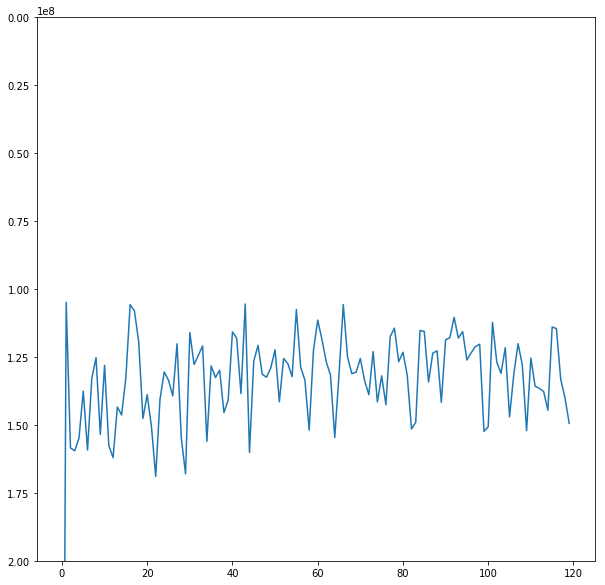

In [25]:
plt.figure(figsize=(10,10))
plt.ylim(2e8)
plt.plot(x[:,2])
plt.show()

# Generate MRF reconstructions

In [4]:
i = 2

In [5]:
regressor = InceptionV4(num_classes=1)
model = "models/reg20epochL1loss"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")
T1_test = np.load("data/T1w_test/T1_norm_volunteer12_" + str(i) + ".npy")[0]

In [6]:
T1_recon = T1fromMRF(MRF, regressor, model, signal_length=9999)

0
409
818
1227
1636
2045
2454
2863
3272
3681
4090
mean:  12641.125269619823


In [7]:
mask = np.load("data/MRF_test_masks/MRF_norm_volunteer12_" + str(i) + ".npy")

# rescale to 0-255
T1_recon = rescale(T1_recon)
T1_test = rescale(T1_test)
MRF_T1 = rescale(np.load("outputs/MRF_dictionary_recon/MRF_norm_volunteer12_" + str(i) + ".npy"))

# mask
T1_recon[mask == 0] = 0

In [8]:
print(psnr(T1_recon, T1_test))
print(psnr(MRF_T1, T1_test))
print(psnr(MRF_T1, T1_recon))

18.770495383447837
15.98680035218871
19.029613017020402


In [9]:
print(ssim(T1_recon, T1_test))
print(ssim(MRF_T1, T1_test))
print(ssim(MRF_T1, T1_recon))

0.19177214026802977
0.1563822415438277
0.7539145305840584


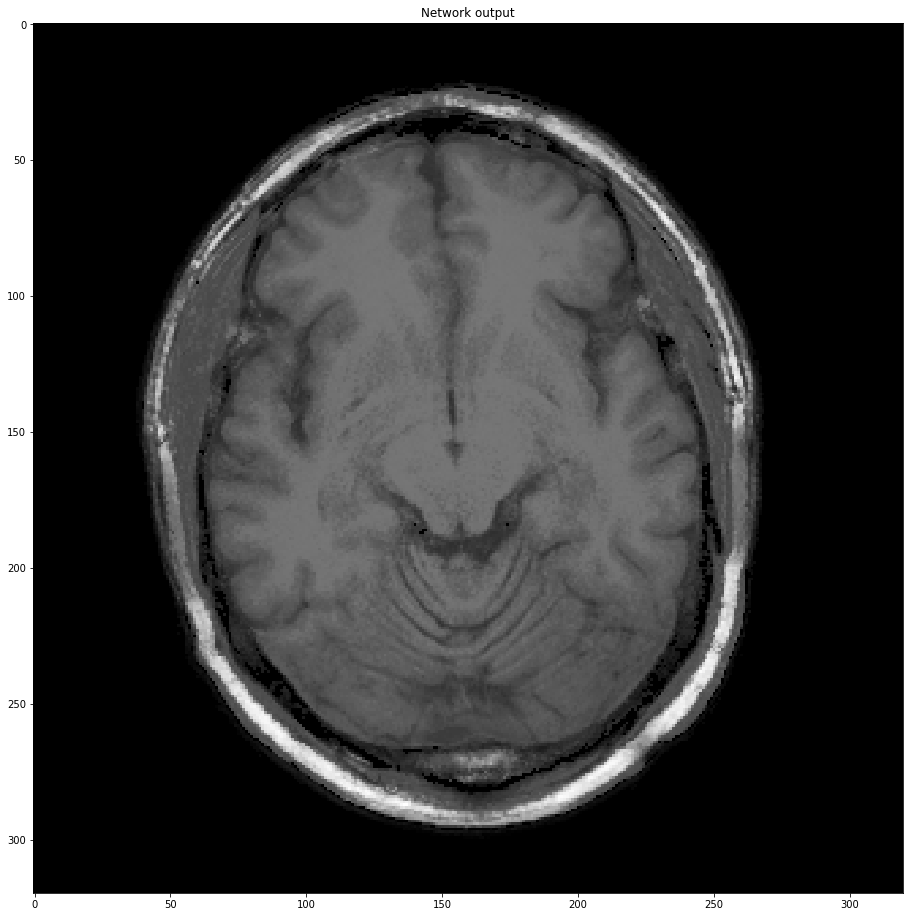

In [10]:
plt.figure(figsize=(16,16))
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray",vmin=0,vmax=255)
plt.savefig(str(i) + "alph0.png")

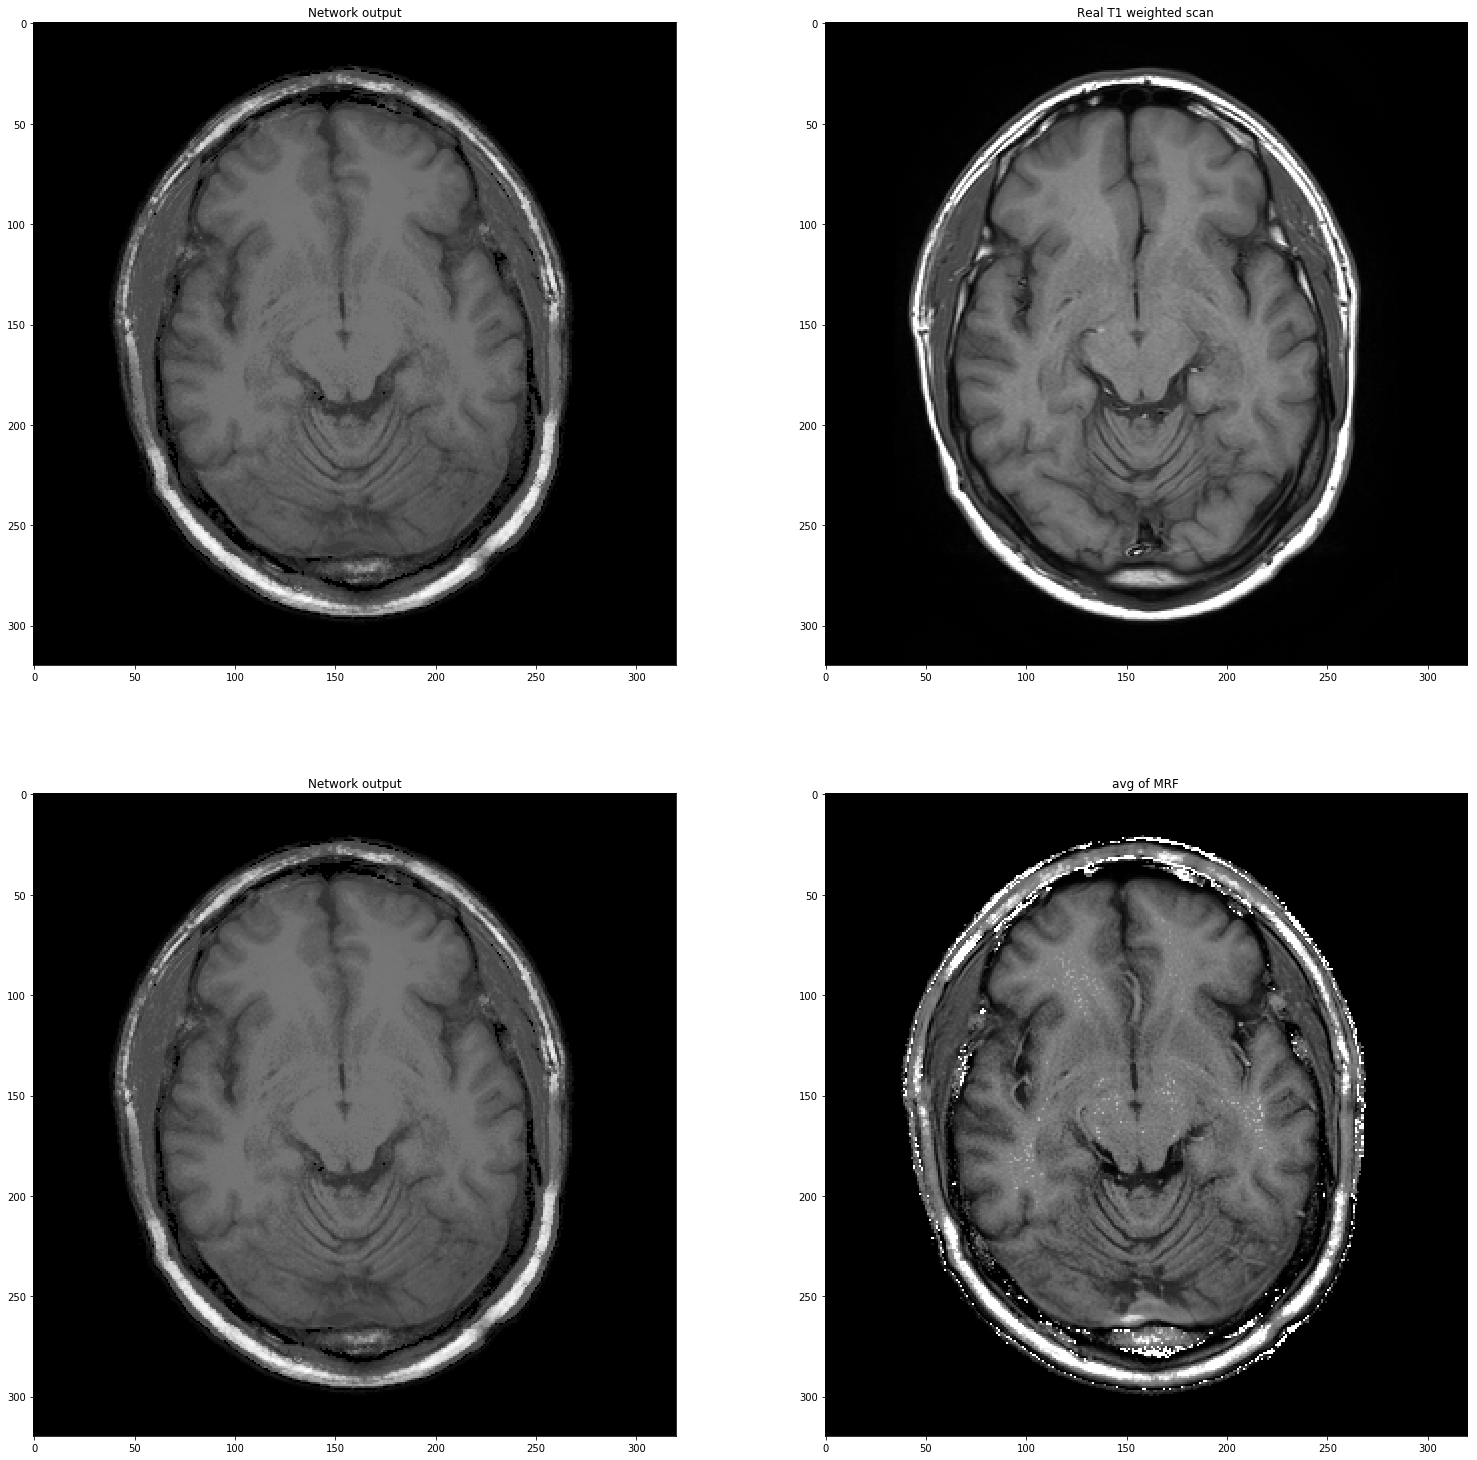

In [11]:
plt.figure(figsize=(26,26))
plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray", vmin=0, vmax=255)
# plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T1_test, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray",vmin=0,vmax=255)

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(MRF_T1, cmap="gray",vmin=0,vmax=255)

# plt.savefig("alpha0.75.png")

# Reconstruction

In [11]:
models = natsort.natsorted(glob.glob("models/normalized*"))

In [ ]:
regressor = InceptionV4(num_classes=256)
for model in models:
    for j in range(1,11):
        MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(j) + ".npy")
        T1_recon = T1fromMRF(MRF, regressor, model)
        np.save("outputs/" + model.split("/")[-1] + "trial" + str(j), T1_recon)

# Compare Reconstructions

In [128]:
testnames = natsort.natsorted(glob.glob("data/T1w_test/*"))

In [133]:
filenames = np.array(natsort.natsorted(glob.glob("outputs/normalized*.npy")))
filenames = filenames.reshape(-1,10)

In [134]:
ssims = []
psnrs = []
for category in filenames:
    for filename, testname in zip(category, testnames):
        recon = np.load(filename)
        test = np.load(testname)[0]
        ssims.append(ssim(rescale(recon),rescale(test)))
        psnrs.append(psnr(rescale(recon),rescale(test)))


In [138]:
alphas = np.round(np.linspace(0,1,6),1)
alphas_repeat = np.repeat(alphas, 10)
ssims_array = np.array(ssims).reshape(-1,10)
psnrs_array = np.array(psnrs).reshape(-1,10)

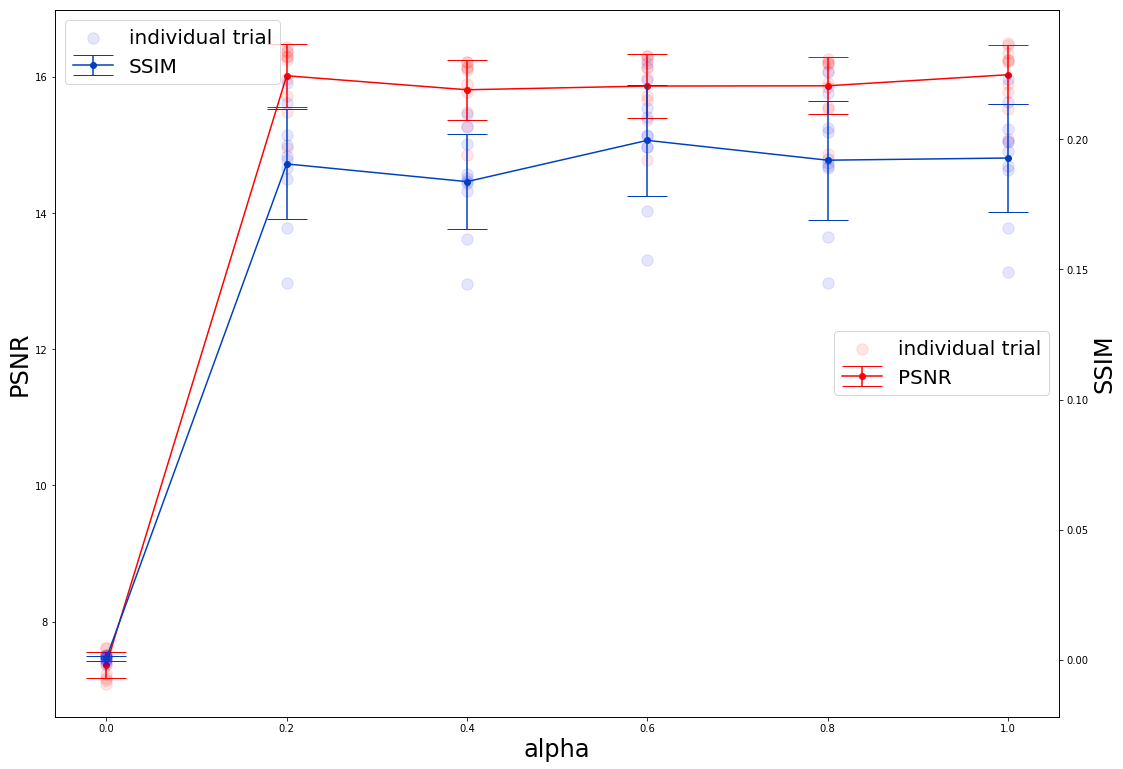

In [151]:
fig1, ax1 = plt.subplots()
fig1.set_figheight(13)
fig1.set_figwidth(18)
ax1.scatter(alphas_repeat, psnrs, s=130, alpha=0.1,c="red", label="individual trial")
ax1.set_ylabel("PSNR", fontsize=24)
ax1.errorbar(alphas, np.mean(psnrs_array, axis=1), np.std(psnrs_array, axis=1), marker='o', c=(1,0,0), capsize=20, label="PSNR")
ax1.set_xlabel("alpha", fontsize=24)

ax2 = ax1.twinx()

ax2.scatter(alphas_repeat, ssims, s=130, alpha=0.1,c="blue", label="individual trial")
ax2.set_ylabel("SSIM", fontsize=24)
ax2.errorbar(alphas, np.mean(ssims_array, axis=1), np.std(ssims_array, axis=1), marker='o', c=(0,0.25,0.75), capsize=20, label="SSIM")

ax1.legend(loc=5, prop={'size': 20})
ax2.legend(prop={'size': 20})

# ax1.set_xlabel("Number of Points",  fontsize=23)
# ax1.set_ylabel("Overall Accuracy", fontsize=23)
# ax1.tick_params(labelsize=20)

# ax1.set_xscale('log')
# ax1.set_xticks([20, 40, 80,160,320,640,1280,2560,5120])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())